In [1]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from tqdm import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

import mNDWS_models as mndws_models
mndws_models.set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)

Loading shared models module from: /sfs/weka/scratch/jbm2rt/DS6050/wildfire-spread-prediction/mNDWS_models.py
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Device: cuda


In [2]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [3]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 32.897
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(32.8968, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [4]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 150
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    yhat = (p >= best_thr).astype(np.float32)
    intersection = float((yhat * t).sum())
    union = float(yhat.sum() + t.sum() - intersection)
    iou = intersection / (union + 1e-8)
    return float(ap), float(f1.max()), float(best_thr), float(iou)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5304 | VAL AP 0.3238 | VAL F1* 0.4415 | VAL IoU 0.2832 | thr≈0.681


[Physics] Epoch 01 | loss 0.5089 | VAL AP 0.3676 | VAL F1* 0.4552 | VAL IoU 0.2946 | thr≈0.660


[Physics] Epoch 02 | loss 0.5019 | VAL AP 0.3785 | VAL F1* 0.4656 | VAL IoU 0.3034 | thr≈0.695


[Physics] Epoch 03 | loss 0.4978 | VAL AP 0.4249 | VAL F1* 0.4842 | VAL IoU 0.3194 | thr≈0.690


[Physics] Epoch 04 | loss 0.4914 | VAL AP 0.4177 | VAL F1* 0.4805 | VAL IoU 0.3162 | thr≈0.682


[Physics] Epoch 05 | loss 0.4885 | VAL AP 0.4274 | VAL F1* 0.4832 | VAL IoU 0.3185 | thr≈0.693


[Physics] Epoch 06 | loss 0.4851 | VAL AP 0.4309 | VAL F1* 0.4836 | VAL IoU 0.3189 | thr≈0.699


[Physics] Epoch 07 | loss 0.4793 | VAL AP 0.4252 | VAL F1* 0.4814 | VAL IoU 0.3170 | thr≈0.702


[Physics] Epoch 08 | loss 0.4771 | VAL AP 0.3838 | VAL F1* 0.4643 | VAL IoU 0.3023 | thr≈0.722


[Physics] Epoch 09 | loss 0.4717 | VAL AP 0.4315 | VAL F1* 0.4842 | VAL IoU 0.3195 | thr≈0.680


[Physics] Epoch 10 | loss 0.4656 | VAL AP 0.4162 | VAL F1* 0.4739 | VAL IoU 0.3105 | thr≈0.680


[Physics] Epoch 11 | loss 0.4580 | VAL AP 0.4024 | VAL F1* 0.4591 | VAL IoU 0.2980 | thr≈0.707


[Physics] Epoch 12 | loss 0.4475 | VAL AP 0.4176 | VAL F1* 0.4730 | VAL IoU 0.3098 | thr≈0.634


[Physics] Epoch 13 | loss 0.4411 | VAL AP 0.4208 | VAL F1* 0.4876 | VAL IoU 0.3224 | thr≈0.656


[Physics] Epoch 14 | loss 0.4300 | VAL AP 0.3788 | VAL F1* 0.4296 | VAL IoU 0.2735 | thr≈0.758


[Physics] Epoch 15 | loss 0.4279 | VAL AP 0.4173 | VAL F1* 0.4753 | VAL IoU 0.3117 | thr≈0.671


[Physics] Epoch 16 | loss 0.4180 | VAL AP 0.4005 | VAL F1* 0.4660 | VAL IoU 0.3038 | thr≈0.629


[Physics] Epoch 17 | loss 0.4143 | VAL AP 0.4121 | VAL F1* 0.4683 | VAL IoU 0.3058 | thr≈0.679


[Physics] Epoch 18 | loss 0.4119 | VAL AP 0.4238 | VAL F1* 0.4873 | VAL IoU 0.3221 | thr≈0.645


[Physics] Epoch 19 | loss 0.4001 | VAL AP 0.4131 | VAL F1* 0.4723 | VAL IoU 0.3092 | thr≈0.697


[Physics] Epoch 20 | loss 0.4013 | VAL AP 0.4258 | VAL F1* 0.4788 | VAL IoU 0.3147 | thr≈0.737


[Physics] Epoch 21 | loss 0.4034 | VAL AP 0.4291 | VAL F1* 0.4991 | VAL IoU 0.3325 | thr≈0.707


[Physics] Epoch 22 | loss 0.3952 | VAL AP 0.4401 | VAL F1* 0.4985 | VAL IoU 0.3320 | thr≈0.620


[Physics] Epoch 23 | loss 0.3929 | VAL AP 0.4316 | VAL F1* 0.4920 | VAL IoU 0.3263 | thr≈0.652


[Physics] Epoch 24 | loss 0.3847 | VAL AP 0.4275 | VAL F1* 0.4947 | VAL IoU 0.3286 | thr≈0.612


[Physics] Epoch 25 | loss 0.3874 | VAL AP 0.4382 | VAL F1* 0.5025 | VAL IoU 0.3356 | thr≈0.603


[Physics] Epoch 26 | loss 0.3786 | VAL AP 0.4440 | VAL F1* 0.5100 | VAL IoU 0.3422 | thr≈0.670


[Physics] Epoch 27 | loss 0.3742 | VAL AP 0.4351 | VAL F1* 0.4992 | VAL IoU 0.3326 | thr≈0.654


[Physics] Epoch 28 | loss 0.3731 | VAL AP 0.4391 | VAL F1* 0.4951 | VAL IoU 0.3289 | thr≈0.689


[Physics] Epoch 29 | loss 0.3658 | VAL AP 0.4339 | VAL F1* 0.4993 | VAL IoU 0.3327 | thr≈0.665


[Physics] Epoch 30 | loss 0.3691 | VAL AP 0.4350 | VAL F1* 0.4976 | VAL IoU 0.3312 | thr≈0.657


[Physics] Epoch 31 | loss 0.3581 | VAL AP 0.4287 | VAL F1* 0.4961 | VAL IoU 0.3299 | thr≈0.681


[Physics] Epoch 32 | loss 0.3563 | VAL AP 0.4462 | VAL F1* 0.5088 | VAL IoU 0.3412 | thr≈0.649


[Physics] Epoch 33 | loss 0.3508 | VAL AP 0.4583 | VAL F1* 0.5165 | VAL IoU 0.3481 | thr≈0.672


[Physics] Epoch 34 | loss 0.3505 | VAL AP 0.4300 | VAL F1* 0.4945 | VAL IoU 0.3285 | thr≈0.636


[Physics] Epoch 35 | loss 0.3498 | VAL AP 0.4421 | VAL F1* 0.5113 | VAL IoU 0.3434 | thr≈0.624


[Physics] Epoch 36 | loss 0.3599 | VAL AP 0.4492 | VAL F1* 0.5134 | VAL IoU 0.3454 | thr≈0.655


[Physics] Epoch 37 | loss 0.3335 | VAL AP 0.4597 | VAL F1* 0.5152 | VAL IoU 0.3470 | thr≈0.649


[Physics] Epoch 38 | loss 0.3344 | VAL AP 0.4496 | VAL F1* 0.5104 | VAL IoU 0.3427 | thr≈0.611


[Physics] Epoch 39 | loss 0.3259 | VAL AP 0.4542 | VAL F1* 0.5150 | VAL IoU 0.3468 | thr≈0.651


[Physics] Epoch 40 | loss 0.3229 | VAL AP 0.4430 | VAL F1* 0.5039 | VAL IoU 0.3368 | thr≈0.704


[Physics] Epoch 41 | loss 0.3208 | VAL AP 0.4512 | VAL F1* 0.5190 | VAL IoU 0.3505 | thr≈0.670


[Physics] Epoch 42 | loss 0.3162 | VAL AP 0.4371 | VAL F1* 0.4856 | VAL IoU 0.3206 | thr≈0.697


[Physics] Epoch 43 | loss 0.3135 | VAL AP 0.4511 | VAL F1* 0.5168 | VAL IoU 0.3484 | thr≈0.666


[Physics] Epoch 44 | loss 0.3053 | VAL AP 0.4732 | VAL F1* 0.5306 | VAL IoU 0.3611 | thr≈0.658


[Physics] Epoch 45 | loss 0.2946 | VAL AP 0.4713 | VAL F1* 0.5257 | VAL IoU 0.3566 | thr≈0.576


[Physics] Epoch 46 | loss 0.2937 | VAL AP 0.4657 | VAL F1* 0.5263 | VAL IoU 0.3571 | thr≈0.627


[Physics] Epoch 47 | loss 0.2868 | VAL AP 0.4606 | VAL F1* 0.5077 | VAL IoU 0.3402 | thr≈0.662


[Physics] Epoch 48 | loss 0.2904 | VAL AP 0.4162 | VAL F1* 0.4718 | VAL IoU 0.3087 | thr≈0.722


[Physics] Epoch 49 | loss 0.2813 | VAL AP 0.4689 | VAL F1* 0.5294 | VAL IoU 0.3600 | thr≈0.595


[Physics] Epoch 50 | loss 0.2766 | VAL AP 0.4728 | VAL F1* 0.5248 | VAL IoU 0.3557 | thr≈0.676


[Physics] Epoch 51 | loss 0.2675 | VAL AP 0.4701 | VAL F1* 0.5189 | VAL IoU 0.3504 | thr≈0.647


[Physics] Epoch 52 | loss 0.2580 | VAL AP 0.4703 | VAL F1* 0.5252 | VAL IoU 0.3562 | thr≈0.598


[Physics] Epoch 53 | loss 0.2485 | VAL AP 0.4688 | VAL F1* 0.5245 | VAL IoU 0.3554 | thr≈0.629


[Physics] Epoch 54 | loss 0.2579 | VAL AP 0.4764 | VAL F1* 0.5359 | VAL IoU 0.3660 | thr≈0.629


[Physics] Epoch 55 | loss 0.2490 | VAL AP 0.4831 | VAL F1* 0.5412 | VAL IoU 0.3710 | thr≈0.672


[Physics] Epoch 56 | loss 0.2383 | VAL AP 0.4734 | VAL F1* 0.5286 | VAL IoU 0.3593 | thr≈0.581


[Physics] Epoch 57 | loss 0.2374 | VAL AP 0.4800 | VAL F1* 0.5284 | VAL IoU 0.3591 | thr≈0.577


[Physics] Epoch 58 | loss 0.2306 | VAL AP 0.4867 | VAL F1* 0.5464 | VAL IoU 0.3759 | thr≈0.613


[Physics] Epoch 59 | loss 0.2173 | VAL AP 0.4955 | VAL F1* 0.5440 | VAL IoU 0.3736 | thr≈0.527


[Physics] Epoch 60 | loss 0.2269 | VAL AP 0.4744 | VAL F1* 0.5353 | VAL IoU 0.3655 | thr≈0.634


[Physics] Epoch 61 | loss 0.2118 | VAL AP 0.4910 | VAL F1* 0.5426 | VAL IoU 0.3723 | thr≈0.488


[Physics] Epoch 62 | loss 0.2078 | VAL AP 0.4898 | VAL F1* 0.5429 | VAL IoU 0.3726 | thr≈0.505


[Physics] Epoch 63 | loss 0.1915 | VAL AP 0.4934 | VAL F1* 0.5540 | VAL IoU 0.3831 | thr≈0.666


[Physics] Epoch 64 | loss 0.2037 | VAL AP 0.4862 | VAL F1* 0.5456 | VAL IoU 0.3751 | thr≈0.686


[Physics] Epoch 65 | loss 0.1871 | VAL AP 0.4930 | VAL F1* 0.5449 | VAL IoU 0.3745 | thr≈0.572


[Physics] Epoch 66 | loss 0.1779 | VAL AP 0.5016 | VAL F1* 0.5503 | VAL IoU 0.3796 | thr≈0.559


[Physics] Epoch 67 | loss 0.1845 | VAL AP 0.4903 | VAL F1* 0.5438 | VAL IoU 0.3734 | thr≈0.599


[Physics] Epoch 68 | loss 0.1781 | VAL AP 0.4855 | VAL F1* 0.5447 | VAL IoU 0.3743 | thr≈0.580


[Physics] Epoch 69 | loss 0.1710 | VAL AP 0.4890 | VAL F1* 0.5419 | VAL IoU 0.3717 | thr≈0.419


[Physics] Epoch 70 | loss 0.1637 | VAL AP 0.4992 | VAL F1* 0.5501 | VAL IoU 0.3794 | thr≈0.500


[Physics] Epoch 71 | loss 0.1556 | VAL AP 0.4996 | VAL F1* 0.5546 | VAL IoU 0.3837 | thr≈0.532


[Physics] Epoch 72 | loss 0.1499 | VAL AP 0.4903 | VAL F1* 0.5531 | VAL IoU 0.3823 | thr≈0.550


[Physics] Epoch 73 | loss 0.1441 | VAL AP 0.5074 | VAL F1* 0.5583 | VAL IoU 0.3873 | thr≈0.495


[Physics] Epoch 74 | loss 0.1549 | VAL AP 0.4968 | VAL F1* 0.5549 | VAL IoU 0.3840 | thr≈0.455


[Physics] Epoch 75 | loss 0.1475 | VAL AP 0.4968 | VAL F1* 0.5491 | VAL IoU 0.3785 | thr≈0.453


[Physics] Epoch 76 | loss 0.1339 | VAL AP 0.4986 | VAL F1* 0.5512 | VAL IoU 0.3805 | thr≈0.359


[Physics] Epoch 77 | loss 0.1306 | VAL AP 0.4718 | VAL F1* 0.5315 | VAL IoU 0.3619 | thr≈0.587


[Physics] Epoch 78 | loss 0.1311 | VAL AP 0.4959 | VAL F1* 0.5500 | VAL IoU 0.3793 | thr≈0.343


[Physics] Epoch 79 | loss 0.1193 | VAL AP 0.5011 | VAL F1* 0.5577 | VAL IoU 0.3867 | thr≈0.402


[Physics] Epoch 80 | loss 0.1151 | VAL AP 0.4980 | VAL F1* 0.5516 | VAL IoU 0.3808 | thr≈0.436


[Physics] Epoch 81 | loss 0.1106 | VAL AP 0.4996 | VAL F1* 0.5599 | VAL IoU 0.3888 | thr≈0.552


[Physics] Epoch 82 | loss 0.1130 | VAL AP 0.4973 | VAL F1* 0.5553 | VAL IoU 0.3844 | thr≈0.340


[Physics] Epoch 83 | loss 0.1061 | VAL AP 0.5022 | VAL F1* 0.5605 | VAL IoU 0.3894 | thr≈0.316


[Physics] Epoch 84 | loss 0.1074 | VAL AP 0.5011 | VAL F1* 0.5555 | VAL IoU 0.3846 | thr≈0.447


[Physics] Epoch 85 | loss 0.1030 | VAL AP 0.5014 | VAL F1* 0.5542 | VAL IoU 0.3833 | thr≈0.382


[Physics] Epoch 86 | loss 0.0940 | VAL AP 0.4978 | VAL F1* 0.5554 | VAL IoU 0.3845 | thr≈0.390


[Physics] Epoch 87 | loss 0.1008 | VAL AP 0.4629 | VAL F1* 0.5236 | VAL IoU 0.3546 | thr≈0.488


[Physics] Epoch 88 | loss 0.0989 | VAL AP 0.5059 | VAL F1* 0.5674 | VAL IoU 0.3960 | thr≈0.530


[Physics] Epoch 89 | loss 0.0894 | VAL AP 0.4975 | VAL F1* 0.5570 | VAL IoU 0.3860 | thr≈0.433


[Physics] Epoch 90 | loss 0.0835 | VAL AP 0.5016 | VAL F1* 0.5683 | VAL IoU 0.3970 | thr≈0.573


[Physics] Epoch 91 | loss 0.0809 | VAL AP 0.5036 | VAL F1* 0.5632 | VAL IoU 0.3920 | thr≈0.297


[Physics] Epoch 92 | loss 0.0818 | VAL AP 0.5029 | VAL F1* 0.5653 | VAL IoU 0.3940 | thr≈0.312


[Physics] Epoch 93 | loss 0.0689 | VAL AP 0.5026 | VAL F1* 0.5592 | VAL IoU 0.3882 | thr≈0.225


[Physics] Epoch 94 | loss 0.0721 | VAL AP 0.4931 | VAL F1* 0.5556 | VAL IoU 0.3846 | thr≈0.192


[Physics] Epoch 95 | loss 0.0740 | VAL AP 0.5018 | VAL F1* 0.5594 | VAL IoU 0.3884 | thr≈0.200


[Physics] Epoch 96 | loss 0.0689 | VAL AP 0.4944 | VAL F1* 0.5529 | VAL IoU 0.3821 | thr≈0.146


[Physics] Epoch 97 | loss 0.0688 | VAL AP 0.5062 | VAL F1* 0.5630 | VAL IoU 0.3918 | thr≈0.220


[Physics] Epoch 98 | loss 0.0649 | VAL AP 0.5024 | VAL F1* 0.5619 | VAL IoU 0.3907 | thr≈0.169


[Physics] Epoch 99 | loss 0.0653 | VAL AP 0.4964 | VAL F1* 0.5621 | VAL IoU 0.3909 | thr≈0.181


[Physics] Epoch 100 | loss 0.0592 | VAL AP 0.4987 | VAL F1* 0.5626 | VAL IoU 0.3914 | thr≈0.346


[Physics] Epoch 101 | loss 0.0555 | VAL AP 0.5053 | VAL F1* 0.5662 | VAL IoU 0.3949 | thr≈0.178


[Physics] Epoch 102 | loss 0.0564 | VAL AP 0.5050 | VAL F1* 0.5635 | VAL IoU 0.3922 | thr≈0.184


[Physics] Epoch 103 | loss 0.0607 | VAL AP 0.4800 | VAL F1* 0.5473 | VAL IoU 0.3767 | thr≈0.073


[Physics] Epoch 104 | loss 0.0618 | VAL AP 0.5050 | VAL F1* 0.5646 | VAL IoU 0.3933 | thr≈0.163


[Physics] Epoch 105 | loss 0.0533 | VAL AP 0.4932 | VAL F1* 0.5598 | VAL IoU 0.3887 | thr≈0.159


[Physics] Epoch 106 | loss 0.0539 | VAL AP 0.4911 | VAL F1* 0.5550 | VAL IoU 0.3841 | thr≈0.116


[Physics] Epoch 107 | loss 0.0508 | VAL AP 0.4992 | VAL F1* 0.5656 | VAL IoU 0.3943 | thr≈0.170


[Physics] Epoch 108 | loss 0.0468 | VAL AP 0.4949 | VAL F1* 0.5589 | VAL IoU 0.3878 | thr≈0.158


[Physics] Epoch 109 | loss 0.0444 | VAL AP 0.5003 | VAL F1* 0.5626 | VAL IoU 0.3914 | thr≈0.385


[Physics] Epoch 110 | loss 0.0486 | VAL AP 0.4965 | VAL F1* 0.5601 | VAL IoU 0.3890 | thr≈0.095


[Physics] Epoch 111 | loss 0.0441 | VAL AP 0.5009 | VAL F1* 0.5623 | VAL IoU 0.3911 | thr≈0.088


[Physics] Epoch 112 | loss 0.0483 | VAL AP 0.4959 | VAL F1* 0.5566 | VAL IoU 0.3857 | thr≈0.174


[Physics] Epoch 113 | loss 0.0420 | VAL AP 0.4940 | VAL F1* 0.5564 | VAL IoU 0.3854 | thr≈0.067


[Physics] Epoch 114 | loss 0.0492 | VAL AP 0.5000 | VAL F1* 0.5666 | VAL IoU 0.3953 | thr≈0.186


[Physics] Epoch 115 | loss 0.0425 | VAL AP 0.5017 | VAL F1* 0.5683 | VAL IoU 0.3970 | thr≈0.143


[Physics] Epoch 116 | loss 0.0378 | VAL AP 0.4943 | VAL F1* 0.5615 | VAL IoU 0.3903 | thr≈0.063


[Physics] Epoch 117 | loss 0.0349 | VAL AP 0.5008 | VAL F1* 0.5625 | VAL IoU 0.3913 | thr≈0.121


[Physics] Epoch 118 | loss 0.0374 | VAL AP 0.4921 | VAL F1* 0.5553 | VAL IoU 0.3844 | thr≈0.126


[Physics] Epoch 119 | loss 0.0339 | VAL AP 0.4896 | VAL F1* 0.5533 | VAL IoU 0.3824 | thr≈0.063


[Physics] Epoch 120 | loss 0.0319 | VAL AP 0.4897 | VAL F1* 0.5592 | VAL IoU 0.3881 | thr≈0.104


[Physics] Epoch 121 | loss 0.0319 | VAL AP 0.4897 | VAL F1* 0.5588 | VAL IoU 0.3877 | thr≈0.059


[Physics] Epoch 122 | loss 0.0312 | VAL AP 0.4889 | VAL F1* 0.5533 | VAL IoU 0.3824 | thr≈0.060


[Physics] Epoch 123 | loss 0.0304 | VAL AP 0.4896 | VAL F1* 0.5601 | VAL IoU 0.3889 | thr≈0.057


[Physics] Epoch 124 | loss 0.0267 | VAL AP 0.4978 | VAL F1* 0.5653 | VAL IoU 0.3941 | thr≈0.143


[Physics] Epoch 125 | loss 0.0300 | VAL AP 0.4934 | VAL F1* 0.5583 | VAL IoU 0.3873 | thr≈0.077


[Physics] Epoch 126 | loss 0.0296 | VAL AP 0.4974 | VAL F1* 0.5639 | VAL IoU 0.3927 | thr≈0.127


[Physics] Epoch 127 | loss 0.0256 | VAL AP 0.4994 | VAL F1* 0.5674 | VAL IoU 0.3961 | thr≈0.242


[Physics] Epoch 128 | loss 0.0284 | VAL AP 0.4878 | VAL F1* 0.5529 | VAL IoU 0.3821 | thr≈0.117


[Physics] Epoch 129 | loss 0.0289 | VAL AP 0.4952 | VAL F1* 0.5633 | VAL IoU 0.3921 | thr≈0.118


[Physics] Epoch 130 | loss 0.0280 | VAL AP 0.4952 | VAL F1* 0.5619 | VAL IoU 0.3907 | thr≈0.061


[Physics] Epoch 131 | loss 0.0237 | VAL AP 0.4958 | VAL F1* 0.5618 | VAL IoU 0.3906 | thr≈0.173


[Physics] Epoch 132 | loss 0.0275 | VAL AP 0.4929 | VAL F1* 0.5600 | VAL IoU 0.3889 | thr≈0.078


[Physics] Epoch 133 | loss 0.0246 | VAL AP 0.4938 | VAL F1* 0.5585 | VAL IoU 0.3875 | thr≈0.067


[Physics] Epoch 134 | loss 0.0265 | VAL AP 0.4964 | VAL F1* 0.5590 | VAL IoU 0.3879 | thr≈0.230


[Physics] Epoch 135 | loss 0.0290 | VAL AP 0.4949 | VAL F1* 0.5634 | VAL IoU 0.3922 | thr≈0.081


[Physics] Epoch 136 | loss 0.0292 | VAL AP 0.4906 | VAL F1* 0.5546 | VAL IoU 0.3837 | thr≈0.081


[Physics] Epoch 137 | loss 0.0251 | VAL AP 0.4960 | VAL F1* 0.5617 | VAL IoU 0.3905 | thr≈0.050


[Physics] Epoch 138 | loss 0.0281 | VAL AP 0.4931 | VAL F1* 0.5611 | VAL IoU 0.3900 | thr≈0.066


[Physics] Epoch 139 | loss 0.0243 | VAL AP 0.4910 | VAL F1* 0.5556 | VAL IoU 0.3847 | thr≈0.069


[Physics] Epoch 140 | loss 0.0191 | VAL AP 0.4927 | VAL F1* 0.5594 | VAL IoU 0.3883 | thr≈0.032


[Physics] Epoch 141 | loss 0.0173 | VAL AP 0.4926 | VAL F1* 0.5611 | VAL IoU 0.3900 | thr≈0.024


[Physics] Epoch 142 | loss 0.0154 | VAL AP 0.4926 | VAL F1* 0.5611 | VAL IoU 0.3899 | thr≈0.037


[Physics] Epoch 143 | loss 0.0162 | VAL AP 0.4860 | VAL F1* 0.5553 | VAL IoU 0.3844 | thr≈0.013


[Physics] Epoch 144 | loss 0.0192 | VAL AP 0.4875 | VAL F1* 0.5535 | VAL IoU 0.3827 | thr≈0.035


[Physics] Epoch 145 | loss 0.0198 | VAL AP 0.4974 | VAL F1* 0.5641 | VAL IoU 0.3928 | thr≈0.065


[Physics] Epoch 146 | loss 0.0170 | VAL AP 0.4954 | VAL F1* 0.5628 | VAL IoU 0.3916 | thr≈0.051


[Physics] Epoch 147 | loss 0.0176 | VAL AP 0.4933 | VAL F1* 0.5566 | VAL IoU 0.3856 | thr≈0.128


[Physics] Epoch 148 | loss 0.0200 | VAL AP 0.4962 | VAL F1* 0.5618 | VAL IoU 0.3907 | thr≈0.023


[Physics] Epoch 149 | loss 0.0165 | VAL AP 0.4821 | VAL F1* 0.5530 | VAL IoU 0.3821 | thr≈0.014


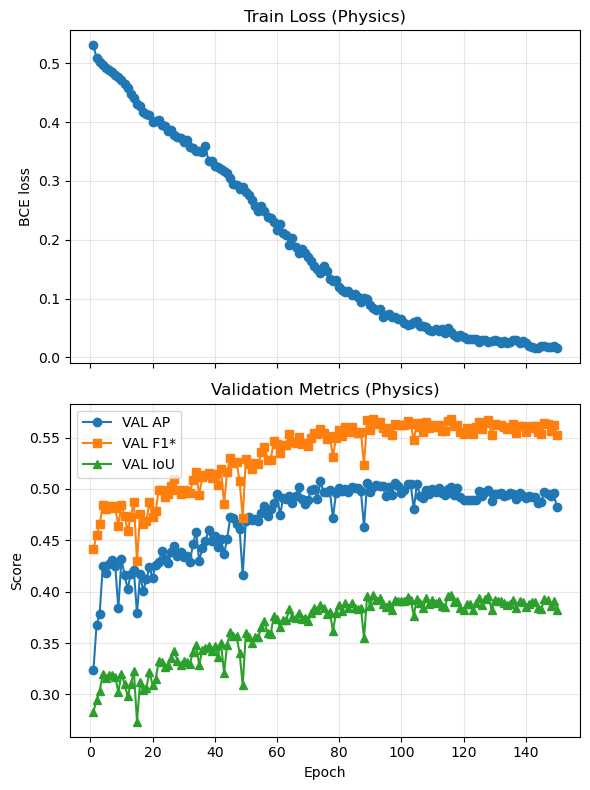

In [5]:
if not train_loss_hist:
    print("Training history empty — rerun the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (Physics)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    if val_iou_hist:
        axes[1].plot(metric_epochs, val_iou_hist, marker="^", label="VAL IoU")
    axes[1].set_title("Validation Metrics (Physics)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()

In [6]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         1.792 s
  Epoch time stdev             2.331 s
  Training throughput          669.511 tiles/s
  Peak GPU memory              2.300 GB
  Inference latency (1 tile)   5.115 ms


In [7]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


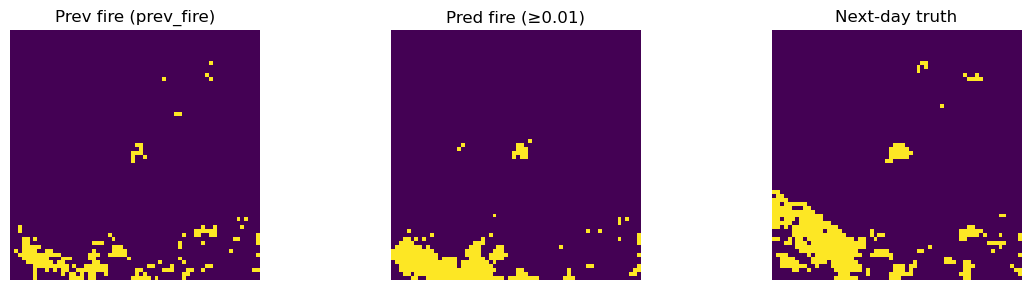

In [8]:
# =========================================================
# Quick qualitative visualization for PhysicsPrior UNet
# =========================================================
@torch.no_grad()
def show_one_physics(ds, model_obj=None, i=0, thr=None):
    if model_obj is None:
        model_obj = physics_model
    if thr is None:
        thr = best_thr_val
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0
    batch = ds[i]
    X_raw0 = batch["X_raw"].unsqueeze(0).to(device)
    y = batch["y"][0].numpy()
    feats = feature_builder(X_raw0)
    prob = torch.sigmoid(model_obj(feats))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(thr)).astype(np.float32)
    prev_img = batch["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1)
    axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1)
    axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1)
    axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout()

# Example
show_one_physics(test_ds, i=0)

In [9]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /home/jbm2rt/wildfire_artifacts/physics_unet/physics_unet.pt


In [10]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.5074 F1 0.5583 IoU 0.3873 thr≈0.495 | TEST AP 0.4752 F1 0.5162 IoU 0.3479
  EMA    | VAL AP 0.5139 F1 0.5717 IoU 0.4003 thr≈0.052 | TEST AP 0.4816 F1 0.5306 IoU 0.3611
  Polyak | VAL AP 0.4987 F1 0.5440 IoU 0.3736 thr≈0.364 | TEST AP 0.4765 F1 0.5155 IoU 0.3473


Using EMA weights for confusion/PR with thr≈0.052
VAL @thr: {'tp': 22342, 'fp': 18512, 'tn': 1172983, 'fn': 14963, 'precision': 0.5468742350808864, 'recall': 0.5989009516149045, 'f1': 0.5717063883877652, 'iou': 0.40027231846921185}
TEST @thr: {'tp': 22230, 'fp': 22771, 'tn': 1167199, 'fn': 16600, 'precision': 0.4939890224660577, 'recall': 0.5724954931752325, 'f1': 0.5303527285026508, 'iou': 0.36087076508492383}


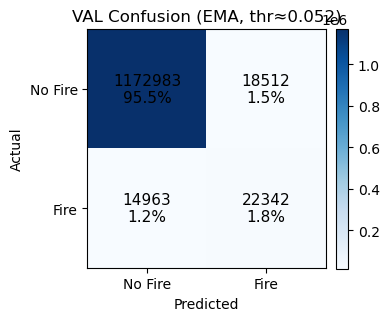

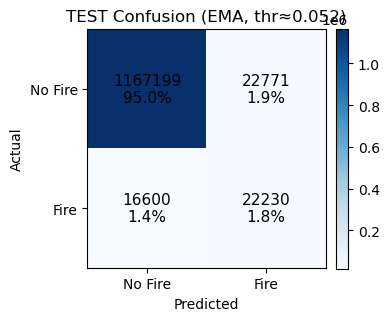

In [11]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1), iou=float(iou))


def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)


def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()


val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


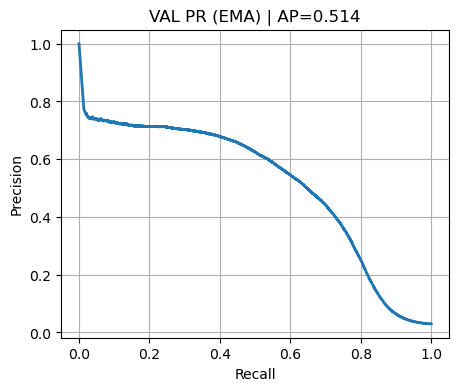

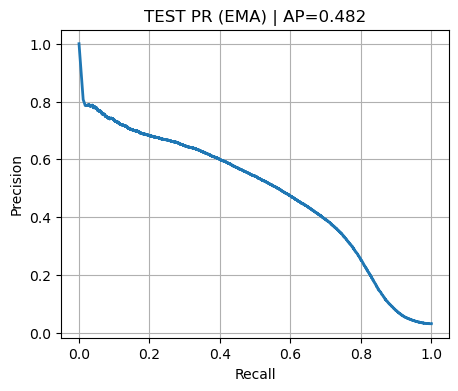

In [12]:
@torch.no_grad()
def pr_curve(model_obj, loader, title="PR Curve"):
    model_obj.eval()
    ps, ts = [], []
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        p = torch.sigmoid(model_obj(feats)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p)
        ts.append(t)
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(best_model, val_loader, f"VAL PR ({best_name})")
pr_curve(best_model, test_loader, f"TEST PR ({best_name})")

TEST metrics: {'ap': 0.4816418379939016, 'best_f1': 0.5306358331712766, 'best_thr': 0.06079067289829254, 'chosen_thr': 0.051623936742544174, 'iou': 0.36087076508492383}
Confusion counts: {'TP': 22230.0, 'FP': 22771.0, 'FN': 16600.0}
Confusion matrix:
 [[1167199   22771]
 [  16600   22230]]


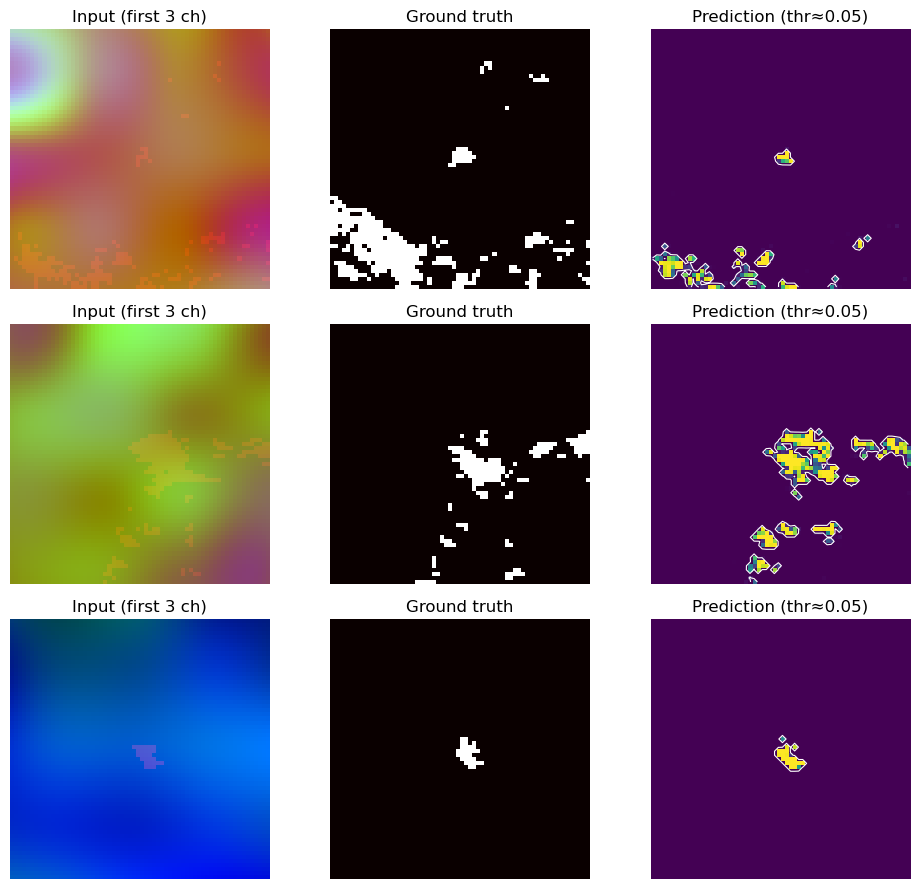

In [13]:
# =========================================================
# Test-set evaluation + qualitative checks
# =========================================================
@torch.no_grad()
def run_test(model_obj, loader, threshold=None, desc="TEST eval"):
    model_obj.eval()
    probs_all, targets_all = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        probs_all.append(torch.sigmoid(logits).detach().cpu())
        targets_all.append(y.detach().cpu())
    probs = torch.cat(probs_all, dim=0)
    targets = torch.cat(targets_all, dim=0)
    p_flat = probs.flatten().numpy()
    t_flat = targets.flatten().numpy()
    ap = average_precision_score(t_flat, p_flat)
    prec, rec, thr = precision_recall_curve(t_flat, p_flat)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr_curve = thr[best_idx] if best_idx < len(thr) else 0.5
    chosen_thr = float(threshold if threshold is not None else best_thr_curve)
    binary = (probs >= chosen_thr).float()
    tp = float((binary * targets).sum().item())
    fp = float((binary * (1 - targets)).sum().item())
    fn = float((((1 - binary) * targets)).sum().item())
    intersection = tp
    union = float(binary.sum().item() + targets.sum().item() - intersection)
    iou = intersection / (union + 1e-8)
    metrics = {
        "ap": float(ap),
        "best_f1": float(f1.max()),
        "best_thr": float(best_thr_curve),
        "chosen_thr": chosen_thr,
        "iou": float(iou),
    }
    confusion_counts = {"TP": tp, "FP": fp, "FN": fn}
    cm = confusion_matrix(t_flat.astype(int), binary.flatten().numpy().astype(int), labels=[0, 1])
    return metrics, confusion_counts, cm


test_metrics, test_confusion, test_cm = run_test(best_model, test_loader, threshold=best_thr, desc=f"TEST {best_name}")
print("TEST metrics:", test_metrics)
print("Confusion counts:", test_confusion)
print("Confusion matrix:\n", test_cm)


@torch.no_grad()
def visualize_predictions(loader, model_obj=None, n=4, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    loader_iter = iter(loader)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))
    axes = np.atleast_2d(axes)
    for row in range(n):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        prob = torch.sigmoid(logits).detach().cpu()
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        gt = y[0, 0].cpu().numpy()
        pred = prob[0, 0].numpy()
        axs = axes[row]
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input (first 3 ch)")
        axs[0].axis("off")
        im1 = axs[1].imshow(gt, cmap="hot")
        axs[1].set_title("Ground truth")
        axs[1].axis("off")
        im2 = axs[2].imshow(pred, cmap="viridis")
        axs[2].contour(pred, levels=[thr], colors="white", linewidths=0.8)
        axs[2].set_title(f"Prediction (thr≈{thr:.2f})")
        axs[2].axis("off")
    plt.tight_layout()


visualize_predictions(test_loader, model_obj=best_model, n=3, threshold=test_metrics.get("chosen_thr", best_thr))

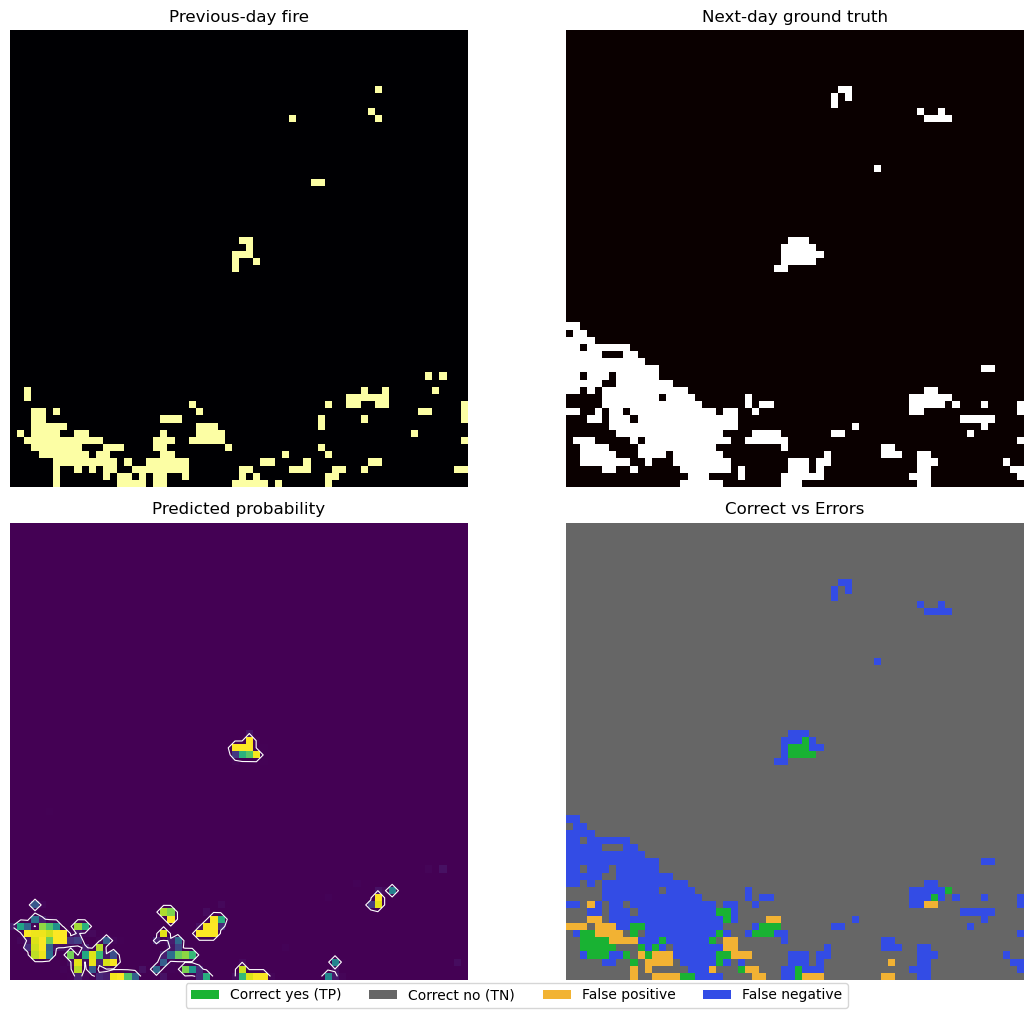

In [14]:
# =========================================================
# Single-tile error-type visualization
# =========================================================
@torch.no_grad()
def plot_error_breakdown(loader, model_obj=None, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    batch = next(iter(loader))
    feats, y = _forward_batch(model_obj, batch)
    logits = model_obj(feats)
    prob = torch.sigmoid(logits).detach().cpu().numpy()[0, 0]
    pred_mask = (prob >= thr).astype(np.float32)
    gt_mask = y[0, 0].cpu().numpy()
    channel_names = getattr(loader.dataset, "channels", CHANNELS_FOR_MODEL)
    prev_idx = channel_names.index("prev_fire") if "prev_fire" in channel_names else 0
    prev_fire = batch["X_raw"][0, prev_idx].cpu().numpy()
    prev_fire = (prev_fire - prev_fire.min()) / (prev_fire.max() - prev_fire.min() + 1e-6)

    correct_yes = np.logical_and(pred_mask == 1, gt_mask == 1)
    correct_no = np.logical_and(pred_mask == 0, gt_mask == 0)
    false_pos = np.logical_and(pred_mask == 1, gt_mask == 0)
    false_neg = np.logical_and(pred_mask == 0, gt_mask == 1)

    palette = {
        "TP": np.array([0.1, 0.7, 0.2]),
        "TN": np.array([0.4, 0.4, 0.4]),
        "FP": np.array([0.95, 0.7, 0.2]),
        "FN": np.array([0.2, 0.3, 0.9]),
    }
    error_map = np.zeros((*gt_mask.shape, 3), dtype=np.float32)
    error_map[correct_yes] = palette["TP"]
    error_map[correct_no] = palette["TN"]
    error_map[false_pos] = palette["FP"]
    error_map[false_neg] = palette["FN"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(prev_fire, cmap="inferno")
    axes[0, 0].set_title("Previous-day fire")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(gt_mask, cmap="hot")
    axes[0, 1].set_title("Next-day ground truth")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(prob, cmap="viridis")
    axes[1, 0].contour(prob, levels=[thr], colors="white", linewidths=0.8)
    axes[1, 0].set_title("Predicted probability")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(error_map)
    axes[1, 1].set_title("Correct vs Errors")
    axes[1, 1].axis("off")

    legend_patches = [
        Patch(facecolor=palette["TP"], edgecolor="none", label="Correct yes (TP)"),
        Patch(facecolor=palette["TN"], edgecolor="none", label="Correct no (TN)"),
        Patch(facecolor=palette["FP"], edgecolor="none", label="False positive"),
        Patch(facecolor=palette["FN"], edgecolor="none", label="False negative"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()


plot_error_breakdown(test_loader, model_obj=best_model, threshold=test_metrics.get("chosen_thr", best_thr))

In [15]:
# =========================================================
# Conditional AP/IoU/F1 for wind and impervious subsets
# =========================================================
@torch.no_grad()
def conditional_subset_metrics(
    artifact_path=ART_PATH,
    loader=test_loader,
    model_variant=None,
    wind_quantile=0.80,
    impervious_quantile=0.95,
):
    """Reload saved weights and report metrics for masked regions."""
    variant_hint = (model_variant or globals().get("best_name", "Polyak")).lower()
    variant_key = {
        "raw": "state_dict",
        "ema": "ema_state_dict",
        "polyak": "polyak_state_dict",
    }.get(variant_hint, "polyak_state_dict")
    artifact = torch.load(artifact_path, map_location="cpu")
    if variant_key not in artifact:
        available = [k for k in artifact.keys() if k.endswith("state_dict")]
        raise KeyError(f"Variant '{variant_hint}' not stored in artifact. Available: {available}")

    cfg = artifact["model"]
    reloaded = models.PhysicsUNet(
        in_ch=cfg["in_ch"],
        out_ch=1,
        base=cfg.get("base", 80),
    ).to(device)
    reloaded.load_state_dict(artifact[variant_key])
    reloaded.eval()

    dataset = loader.dataset
    channel_names = getattr(dataset, "channels", CHANNELS_FOR_MODEL)
    name_to_idx = {name: idx for idx, name in enumerate(channel_names)}
    wind_channel = "wind_75" if "wind_75" in name_to_idx else ("gust_med" if "gust_med" in name_to_idx else None)
    if wind_channel is None:
        raise ValueError(f"No wind velocity channel found in dataset channels: {channel_names}")
    if "impervious" not in name_to_idx:
        raise ValueError(f"Channel 'impervious' missing from dataset channels: {channel_names}")
    wind_idx = name_to_idx[wind_channel]
    imp_idx = name_to_idx["impervious"]

    probs_list, targets_list = [], []
    wind_list, imp_list = [], []
    for batch in tqdm(loader, desc="Conditional metrics sweep", leave=False):
        feats, y = _forward_batch(reloaded, batch)
        logits = reloaded(feats)
        probs_list.append(torch.sigmoid(logits).detach().cpu().numpy().astype(np.float32).reshape(-1))
        targets_list.append(y.detach().cpu().numpy().astype(np.float32).reshape(-1))
        raw = batch["X_raw"].detach().cpu()
        wind_list.append(raw[:, wind_idx].numpy().astype(np.float32).reshape(-1))
        imp_list.append(raw[:, imp_idx].numpy().astype(np.float32).reshape(-1))

    probs = np.concatenate(probs_list, dtype=np.float32)
    targets = np.concatenate(targets_list, dtype=np.float32)
    wind_vals = np.concatenate(wind_list, dtype=np.float32)
    imp_vals = np.concatenate(imp_list, dtype=np.float32)

    wind_valid = wind_vals[np.isfinite(wind_vals)]
    imp_valid = imp_vals[np.isfinite(imp_vals)]
    if wind_valid.size == 0 or imp_valid.size == 0:
        raise ValueError("Wind or impervious channels contain no valid values for thresholding.")
    wind_thr = float(np.nanquantile(wind_valid, wind_quantile))
    imp_thr = float(np.nanquantile(imp_valid, impervious_quantile))

    def subset_metrics(mask, label):
        mask = mask & np.isfinite(probs) & np.isfinite(targets)
        pixel_count = int(mask.sum())
        if pixel_count == 0:
            return dict(label=label, pixels=0, positives=0, ap=float("nan"), f1=float("nan"), iou=float("nan"), best_thr=float("nan"))
        p = probs[mask]
        t = targets[mask]
        pos = int(t.sum())
        if pos == 0:
            return dict(label=label, pixels=pixel_count, positives=0, ap=0.0, f1=0.0, iou=0.0, best_thr=float("nan"))
        ap = float(average_precision_score(t, p))
        prec, rec, thr = precision_recall_curve(t, p)
        f1_curve = (2 * prec * rec) / (prec + rec + 1e-8)
        best_idx = int(f1_curve.argmax())
        best_thr_subset = float(thr[best_idx]) if best_idx < len(thr) else 0.5
        binary = (p >= best_thr_subset).astype(np.float32)
        tp = float((binary * t).sum())
        fp = float((binary * (1 - t)).sum())
        fn = float(((1 - binary) * t).sum())
        iou = tp / (tp + fp + fn + 1e-8)
        return dict(label=label, pixels=pixel_count, positives=pos, ap=ap, f1=float(f1_curve[best_idx]), iou=float(iou), best_thr=best_thr_subset)

    wind_groups = [
        subset_metrics((wind_vals >= wind_thr) & np.isfinite(wind_vals), f"High wind (≥{wind_thr:.3f} {wind_channel})"),
        subset_metrics((wind_vals < wind_thr) & np.isfinite(wind_vals), f"Other wind (<{wind_thr:.3f})"),
    ]
    imp_groups = [
        subset_metrics((imp_vals >= imp_thr) & np.isfinite(imp_vals), f"High impervious (≥{imp_thr:.3f})"),
        subset_metrics((imp_vals < imp_thr) & np.isfinite(imp_vals), f"Other impervious (<{imp_thr:.3f})"),
    ]

    def _print_group(group, header):
        print(f"\n{header}")
        for res in group:
            print(
                f"  - {res['label']}: pixels={res['pixels']:,} positives={res['positives']:,} | "
                f"AP={res['ap']:.4f} | F1={res['f1']:.4f} | IoU={res['iou']:.4f} | best_thr≈{res['best_thr']:.3f}"
            )

    print(f"Loaded '{variant_hint.capitalize()}' weights from {artifact_path}")
    print(
        f"Wind threshold uses the {wind_quantile:.0%} percentile; "
        f"impervious threshold uses the {impervious_quantile:.0%} percentile."
    )
    _print_group(wind_groups, f"Wind-conditioned metrics (channel: {wind_channel})")
    _print_group(imp_groups, "Impervious-conditioned metrics")


conditional_subset_metrics()

Loaded 'Ema' weights from /home/jbm2rt/wildfire_artifacts/physics_unet/physics_unet.pt
Wind threshold uses the 80% percentile; impervious threshold uses the 95% percentile.

Wind-conditioned metrics (channel: wind_75)
  - High wind (≥4.326 wind_75): pixels=245,760 positives=6,867 | AP=0.4416 | F1=0.4843 | IoU=0.3195 | best_thr≈0.052
  - Other wind (<4.326): pixels=983,040 positives=31,963 | AP=0.4904 | F1=0.5410 | IoU=0.3708 | best_thr≈0.061

Impervious-conditioned metrics
  - High impervious (≥0.020): pixels=92,497 positives=2,620 | AP=0.4424 | F1=0.5059 | IoU=0.3386 | best_thr≈0.031
  - Other impervious (<0.020): pixels=1,136,303 positives=36,210 | AP=0.4843 | F1=0.5325 | IoU=0.3629 | best_thr≈0.061
